Implementation of LSTM for TACTUS
1. Joint angles included
2. Neutral Class included
3. No PCA

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
from sklearn import metrics
import random
from random import randint
import time
import os



In [208]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [252]:
features_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GDP3/initial_implementation/Action_recognition/data_proc/features_X_434N.csv")
features_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GDP3/initial_implementation/Action_recognition/data_proc/features_Y_434N.csv")

In [253]:
features_data.columns = ["default_"]
features_data_ = features_data["default_"].str.split(" ", expand=True)

features_data_.to_csv("features_434X.csv")

features_labels.columns = ["labels"]
features_labels.to_csv("features_434Y.csv")

In [254]:
data_x = pd.read_csv("/content/features_434X.csv")
data_y = pd.read_csv("/content/features_434Y.csv")

In [255]:
data_x = data_x.drop('Unnamed: 0', axis=1)

In [256]:
y = data_y.labels
X = data_x
features_labels = X.columns
RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
RF.fit(X,y)
features_imp = RF.feature_importances_

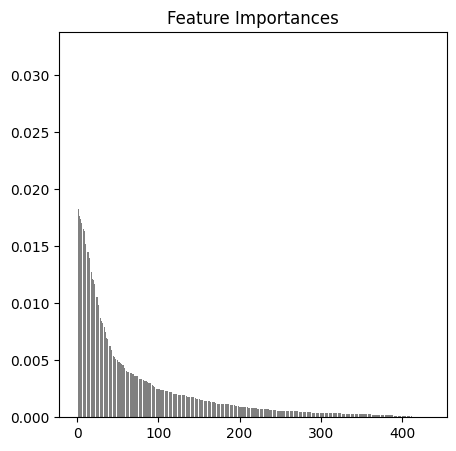

In [257]:
indices = np.argsort(features_imp)[::-1]
    
# Visualization
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), features_imp[indices], color = "grey", align = "center")
#plt.xticks(range(X.shape[1]), features_labels, rotation = 90)
plt.show()

In [121]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [279]:
X["labels"] = y.values

In [280]:
label_map = {0: 'kicking', 1: 'punching', 2: 'pushing', 3: 'neutral'}


X["labels"] = X["labels"].map(label_map)



In [282]:
df_train = X[X.index < 800]
df_test = X[X.index > 800]

In [283]:
print(df_train.shape, df_test.shape)

(800, 435) (512, 435)


In [284]:

scale_columns = X.columns.values[:-1]

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())

df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names



In [285]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [286]:
X.columns.values[-1]

'labels'

In [287]:
TIME_STEPS = 10
STEP = 5
X_train, y_train = create_dataset(
    df_train[X.columns.values[:-1]],
    df_train.labels,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[X.columns.values[:-1]],
    df_test.labels,
    TIME_STEPS,
    STEP
)

<ipython-input-285-3b9516ad6f1d>:7: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

<ipython-input-285-3b9516ad6f1d>:7: DeprecationWarning:

Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.

<ipython-input-285-3b9516ad6f1d>:7: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will be

In time series analysis and sequence modeling, time steps refer to the number of time units between each observation or data point. In this context, the TIME_STEPS parameter defines how many time steps the LSTM model should look back to make a prediction.

1. TIME_STEPS is set to 10, the LSTM model will consider the previous 10 time steps of the time series data to make a prediction for the next time step.

2. By setting STEP to 5, we are specifying that the model should use every 5th data point to create a new sequence. This is done to reduce the overlap between the sequences and prevent overfitting.

In [288]:
print(X_train.shape, y_train.shape)

(158, 10, 434) (158, 1)


1. The input shape is (984, 435), with 984 rows and 435 columns.
2. We set time_steps to 10, which means each sample will consist of 10 timesteps.
3. We set step to 5, which means we will skip every 5 timesteps when creating the next sample. This results in a 50% overlap between consecutive samples.
4. To determine the number of samples we can create from the input data, we first subtract the time_steps from the total number of rows, and then divide by the step. This gives us (984 - 10) / 5 + 1 = 194 samples.
5. Each sample has time_steps of 10 and 435 columns, resulting in a shape of (10, 435).
6. We stack these samples together to create a 3D tensor of shape (194, 10, 435).

In [289]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [290]:
import keras
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [291]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 142 samples, validate on 16 samples
Epoch 1/20
128/142 [==========================>...] - ETA: 0s - loss: 1.2931 - acc: 0.4297

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



142/142 [==============================] - 1s 8ms/sample - loss: 1.3012 - acc: 0.4296 - val_loss: 0.9844 - val_acc: 0.6875
Epoch 2/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.5762 - acc: 0.9155 - val_loss: 0.7199 - val_acc: 0.8750
Epoch 3/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.3087 - acc: 0.9296 - val_loss: 0.5374 - val_acc: 1.0000
Epoch 4/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.1482 - acc: 0.9930 - val_loss: 0.4293 - val_acc: 1.0000
Epoch 5/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.0935 - acc: 1.0000 - val_loss: 0.3560 - val_acc: 1.0000
Epoch 6/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.0625 - acc: 1.0000 - val_loss: 0.3132 - val_acc: 1.0000
Epoch 7/20
142/142 [==============================] - 0s 2ms/sample - loss: 0.0408 - acc: 1.0000 - val_loss: 0.2917 - val_acc: 1.0000
Epoch 8/20
142/142 [==============================] - 0s 2ms/sample - los

In [292]:
model.evaluate(X_test, y_test)

[0.5787558791661026, 0.85148513]

Model overfits
Or LSTM model is too complicated for this type of data
a simple model like SVM or MLP will also do the job!

In [293]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



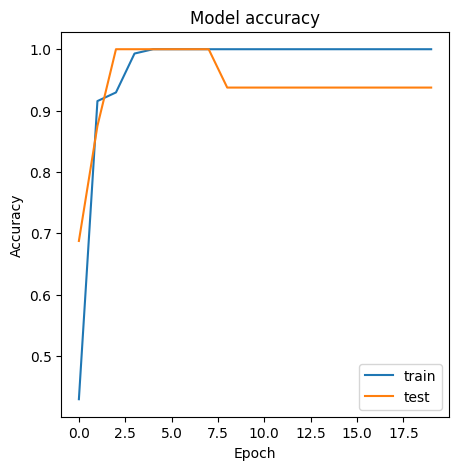

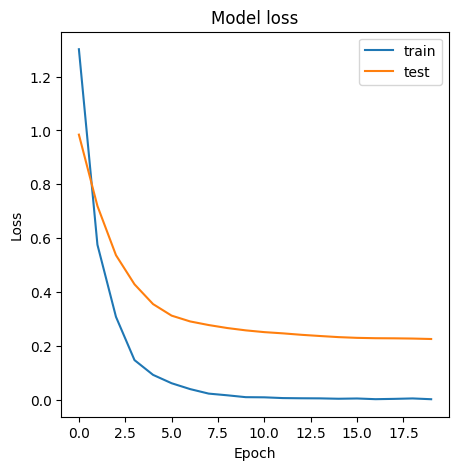

In [294]:
# plot train-test accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# plot train-test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [302]:
y_predicted = np.argmax(y_pred, axis=1)


In [298]:
y_true = np.argmax(y_test, axis=1)


In [301]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import metrics
classes=[0,1,2,3]
plt.rcParams["figure.figsize"] = (5,5)
confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)
cm_display.plot()
plt.show()